In [1]:
import os
notebook_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
data_dir = os.path.join(root_dir, 'data')

import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import ipywidgets as widgets
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import brier_score_loss, make_scorer, log_loss, mean_squared_error
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.metrics import log_loss
from IPython.display import display, HTML
import pickle
from sklearn.model_selection import GroupKFold, RandomizedSearchCV, cross_val_predict
import scipy
def uniform_distribution(lo, hi):
    return scipy.stats.uniform(lo, hi - lo)
def ProbaScoreProxy(y_true, y_probs, proxied_func, **kwargs):
    return proxied_func(y_true, y_probs, **kwargs)
from sklearn import calibration



In [2]:
event_df = pd.read_parquet(os.path.join(data_dir, "event_data.parquet"))
event_df["time_left_in_game"] = np.where(event_df["quarter"] <= 4, event_df["play_start_time"] + (4 - event_df["quarter"]) * 900, event_df["play_start_time"])
event_df["time_elapsed"] = 900 - event_df["play_start_time"] + (event_df["quarter"] - 1) * 900
event_df["score_time_multiplied"] = event_df["time_elapsed"] * event_df["current_score_diff"]


In [3]:
def create_train_test_val_df(
    df,
    input_names,
    output_name,
    mask_train=(event_df.season <= 2019) & (event_df.continuation == 0),
    mask_test=(event_df.season == 2021) & (event_df.continuation == 0),
    mask_val=(event_df.season == 2020) & (event_df.continuation == 0),
):
    X_train = event_df.loc[mask_train, input_names]
    y_train = event_df.loc[mask_train, output_name_base]
    X_test = event_df.loc[mask_test, input_names]
    y_test = event_df.loc[mask_test, output_name_base]
    X_val = event_df.loc[mask_val, input_names]
    y_val = event_df.loc[mask_val, output_name_base]
    return X_train, y_train, X_test, y_test, X_val, y_val


In [4]:
mask_train = (event_df.season<=2019)&(event_df.continuation==0)
mask_test = (event_df.season==2021)&(event_df.continuation==0)
mask_val = (event_df.season==2020)&(event_df.continuation==0)
input_names_base = ["time_left_in_game", "current_score_diff"]
output_name_base = "home_team_win"

X_train, y_train, X_test, y_test, X_val, y_val = create_train_test_val_df(event_df, input_names_base, output_name_base)
naive_prediction = np.mean(event_df.drop_duplicates("game_code").loc[mask_train, output_name_base])
base_model = LogisticRegression(solver='liblinear', random_state=0)
base_model.fit(X_train, y_train)
mlp = MLPClassifier(hidden_layer_sizes=[100], verbose=True, early_stopping=True, n_iter_no_change=5)
mlp.fit(X_train, y_train)

Iteration 1, loss = 0.68724696
Validation score: 0.713750


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 2, loss = 0.64164480
Validation score: 0.717045


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 3, loss = 0.64017759
Validation score: 0.743998


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 4, loss = 0.63840083
Validation score: 0.740337


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 5, loss = 0.63107524
Validation score: 0.745846


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 6, loss = 0.61442403
Validation score: 0.712042


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 7, loss = 0.60967705
Validation score: 0.641748


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 8, loss = 0.60560441
Validation score: 0.665876


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 9, loss = 0.60371222
Validation score: 0.696212


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 10, loss = 0.60908355
Validation score: 0.738419


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 11, loss = 0.60165013
Validation score: 0.728709
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


MLPClassifier(early_stopping=True, hidden_layer_sizes=[100], n_iter_no_change=5,
              verbose=True)

In [12]:
base_model.coef_

array([[3.89892265e-05, 1.69898566e-01]])

In [26]:
eval_mlp_df = pd.concat([X_val, y_val, pd.DataFrame(mlp.predict_proba(X_val), index=X_val.index, columns=["xhome_team_no_win", "xhome_team_win"])], axis=1)
eval_mlp_df["naive_prediction"] = naive_prediction
eval_mlp_df["minute_bucket"] = round((3600 - eval_mlp_df["time_left_in_game"])/60)
eval_mlp_df["naive_error"] = (eval_mlp_df["naive_prediction"] - eval_mlp_df[output_name_base]) ** 2
eval_mlp_df["mlp_error"] = (eval_mlp_df["x"+output_name_base] - eval_mlp_df[output_name_base]) ** 2

print(np.mean(eval_mlp_df["naive_error"]))
np.mean(eval_mlp_df["mlp_error"])


0.2547880065690143


0.16987149660637668

In [28]:
print(np.mean(eval_mlp_df[eval_mlp_df["time_left_in_game"]==3600]["naive_error"]))
np.mean(eval_mlp_df[eval_mlp_df["time_left_in_game"]==3600]["mlp_error"])


0.253684254352153


0.2561134660575575

In [30]:
eval_base_df = pd.concat([X_val, y_val, pd.DataFrame(base_model.predict_proba(X_val), index=X_val.index, columns=["xhome_team_no_win", "xhome_team_win"])], axis=1)
eval_base_df["naive_prediction"] = naive_prediction
eval_base_df["minute_bucket"] = round((3600 - eval_base_df["time_left_in_game"])/60)
eval_base_df["naive_error"] = (eval_base_df["naive_prediction"] - eval_base_df[output_name_base]) ** 2
eval_base_df["base_error"] = (eval_base_df["x"+output_name_base] - eval_base_df[output_name_base]) ** 2

print(np.mean(eval_base_df[eval_base_df["time_left_in_game"]==3600]["base_error"]))
np.mean(eval_base_df["base_error"])


0.2510386896195765


0.17016621548677044

In [7]:
input_names_second = ["score_time_multiplied"]


X_train, y_train, X_val, y_val, X_val, y_val = create_train_test_val_df(event_df, input_names_second, output_name_base)


second_model = LogisticRegression(solver='liblinear', random_state=0)
second_model.fit(X_train, y_train)

eval_second_df = pd.concat([X_val, event_df.loc[mask_val, "time_left_in_game"], y_val, pd.DataFrame(second_model.predict_proba(X_val), index=X_val.index, columns=["xhome_team_no_win", "xhome_team_win"])], axis=1)
eval_second_df["naive_prediction"] = naive_prediction
eval_second_df["minute_bucket"] = round((3600 - eval_second_df["time_left_in_game"])/60)
eval_second_df["naive_error"] = (eval_second_df["naive_prediction"] - eval_second_df[output_name_base]) ** 2
eval_second_df["second_error"] = (eval_second_df["x"+output_name_base] - eval_second_df[output_name_base]) ** 2

np.mean(eval_second_df["second_error"])

0.1648023277125642

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


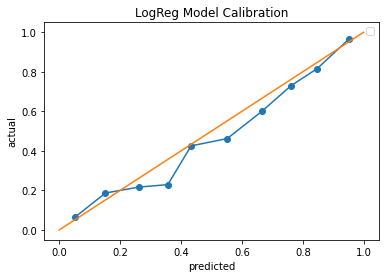

In [37]:
calb_df = eval_base_df
calb = calibration.calibration_curve(calb_df[output_name_base], calb_df["x"+output_name_base], n_bins=10)
plt.plot(calb[1], calb[0], marker = "o")


plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("LogReg Model Calibration")
plt.legend()
plt.plot([0, 1], [0, 1])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


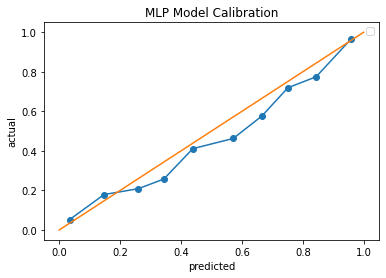

In [33]:
calb_df = eval_mlp_df
calb = calibration.calibration_curve(calb_df[output_name_base], calb_df["x"+output_name_base], n_bins=10)
plt.plot(calb[1], calb[0], marker = "o")

plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("MLP Model Calibration")
plt.legend()
plt.plot([0, 1], [0, 1])

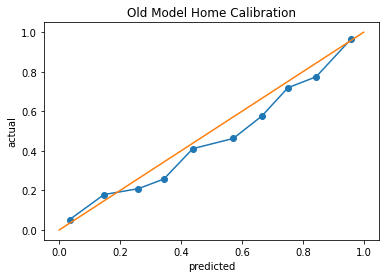

In [9]:
calb_df = eval_mlp_df
calb = calibration.calibration_curve(calb_df[output_name_base], calb_df["x"+output_name_base], n_bins=10)
plt.plot(calb[1], calb[0], marker = "o")
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("Old Model Home Calibration")

plt.plot([0, 1], [0, 1])

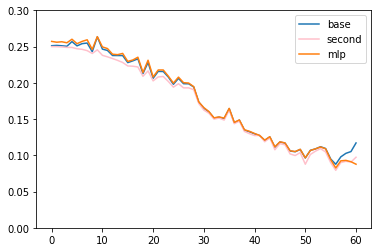

In [10]:
plot_input_by_minute_base = eval_base_df.groupby("minute_bucket", as_index=False).mean()#[["minute_bucket", "naive_error", "base_error"]]
plot_input_by_minute_second = eval_second_df.groupby("minute_bucket", as_index=False).mean()#[["minute_bucket", "naive_error", "second_error"]]
plot_input_by_minute_mlp = eval_mlp_df.groupby("minute_bucket", as_index=False).mean()#[["minute_bucket", "naive_error", "second_error"]]
plt.plot(plot_input_by_minute_base["minute_bucket"], plot_input_by_minute_base["base_error"], label="base")
plt.plot(plot_input_by_minute_second["minute_bucket"], plot_input_by_minute_second["second_error"], label="second", color="pink")
plt.plot(plot_input_by_minute_mlp["minute_bucket"], plot_input_by_minute_mlp["mlp_error"], label="mlp")
plt.ylim([0, 0.3])
plt.legend()
# plt.plot(plot_input_by_minute["minute_bucket"], plot_input_by_minute["naive_error"])

(0.0, 0.3)

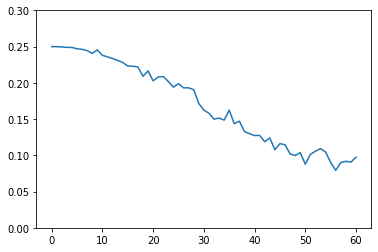

In [11]:
plt.plot(plot_input_by_minute_second["minute_bucket"], plot_input_by_minute_second["second_error"])
plt.ylim([0, 0.3])
# plt.plot(plot_input_by_minute["minute_bucket"], plot_input_by_minute["naive_error"])